In [62]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils
from utils.callbacks import EvalCallback

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnvV2 as StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

from finrl.plot import backtest_stats

from utils.file_utils import uniquify

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
HYPERPARAMETERS_PATH = r'..\experiments\PETR4_012017_122018\TEST_ENV_V2_DDPG_0.5_TECH_FUND\tuning'

In [65]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print('ENV KWARGS')
print(env_kwargs, '\n')
print('ARGS')
print(args)

# TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
# os.makedirs(TEST_PATH, exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

ENV KWARGS
{'stock_dim': 1, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 26, 'action_space': 1, 'tech_indicator_list': ['LPA', 'VPA', 'P/L', 'P/EBITDA', 'P/VPA', 'DL/PL', 'DL/EBITDA', 'ROE', 'MARGEM_EBITDA', 'DL/EBIT', 'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000, 'perc_hmax': 0.5} 

ARGS
{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 0.5, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 20, 'n_repeats_by_trial': 3, 'output_path': '', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundame

In [66]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric  \
                                                                 mean   
9      9  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  3.112664   
13    13  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  3.024754   
10    10  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  2.977706   
2      2  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  2.933733   
17    17  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  2.837956   

              
         std  
9   0.284768  
13  0.654754  
10  0.381739  
2   2.408561  
17  0.364918

Best Trial: 9 | Mean Metric: 3.1127 +- 0.2848


{'gamma': 0.99,
 'learning_starts': 2000,
 'learning_rate': 0.0010464352694912159,
 'batch_size': 128,
 'buffer_size': 100000,
 'train_freq': (256, 'step')}

In [67]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, '2021-01-01', '2021-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 1.098681634563044
Eval	 0.2960293754293346
Trade	 0.14384799157890416


USANDO BEST MODEL
TIMESTEPS: 8245


,Model,Buy and Hold
Annual return,0.065198,0.072482
Cumulative returns,0.128974,0.143848
Annual volatility,0.492520,0.580281
Sharpe ratio,0.387392,0.424109
Calmar ratio,0.103420,0.114405
Stability,0.337360,0.398792
Max drawdown,-0.630420,-0.633561
Omega ratio,1.111792,1.089995
Sortino ratio,0.514862,0.567288
Skew,NaN,NaN


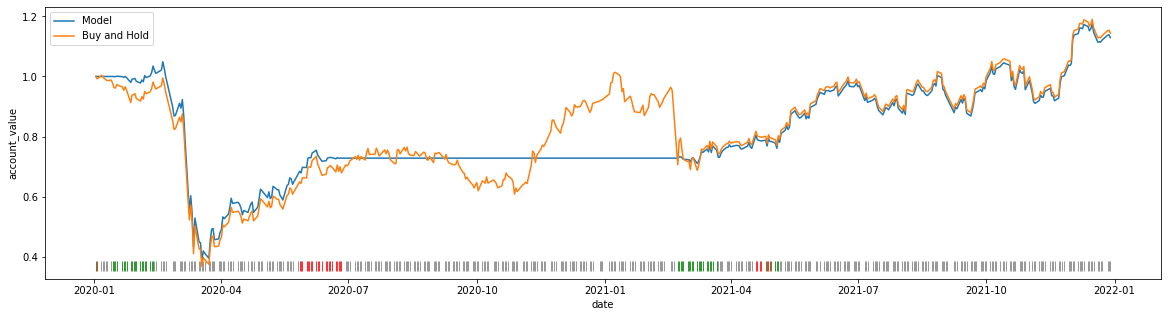

USANDO BEST MODEL
TIMESTEPS: 7275


,Model,Buy and Hold
Annual return,-0.018935,0.072482
Cumulative returns,-0.036050,0.143848
Annual volatility,0.483076,0.580281
Sharpe ratio,0.214960,0.424109
Calmar ratio,-0.030035,0.114405
Stability,0.166924,0.398792
Max drawdown,-0.630437,-0.633561
Omega ratio,1.062937,1.089995
Sortino ratio,0.281826,0.567288
Skew,NaN,NaN


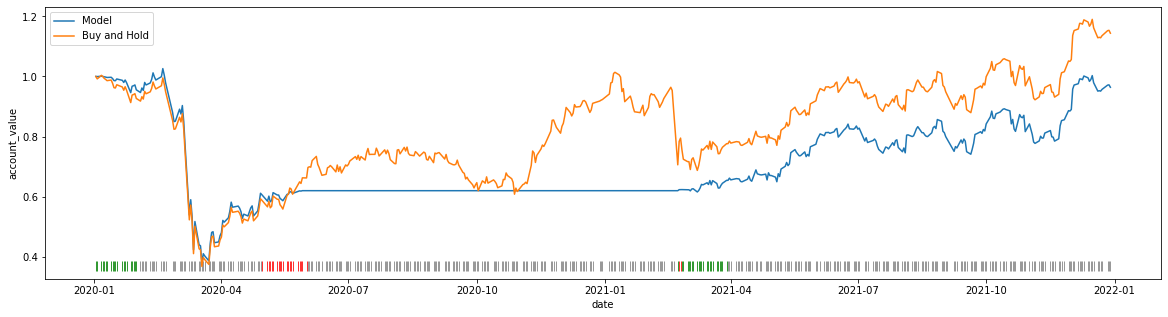

USANDO BEST MODEL
TIMESTEPS: 9700


,Model,Buy and Hold
Annual return,-0.020071,0.072482
Cumulative returns,-0.038193,0.143848
Annual volatility,0.484519,0.580281
Sharpe ratio,0.213358,0.424109
Calmar ratio,-0.031837,0.114405
Stability,0.162805,0.398792
Max drawdown,-0.630431,-0.633561
Omega ratio,1.061760,1.089995
Sortino ratio,0.279933,0.567288
Skew,NaN,NaN


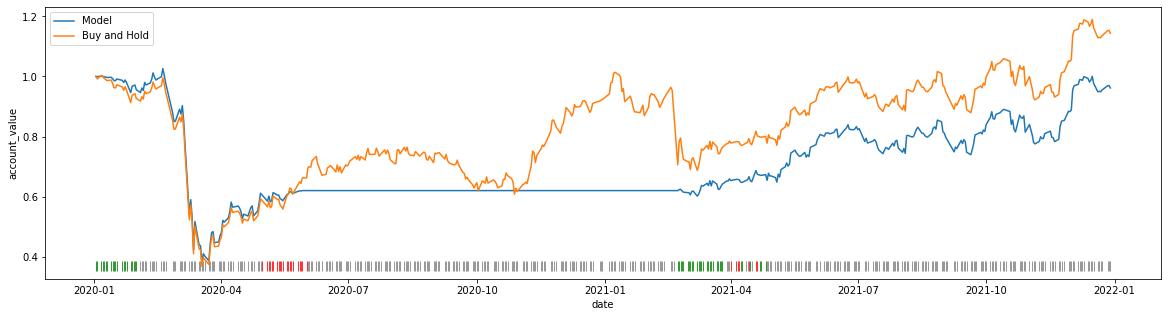

[Errno 2] No such file or directory: '..\\experiments\\PETR4_012017_122018\\TEST_ENV_V2_DDPG_0.05_TECH_FUND\\tuning\\models\\TRIAL_5_REPEAT_3\\env_statistics_best'


In [24]:
a = 5

MODEL_TYPE = 'best' # ?'best' or 'final'

for b in range(0, 10):
    try:
        dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
        dataset['date'] = pd.to_datetime(dataset['date'])

        e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
        env_eval = DummyVecEnv([lambda: e_eval_gym])

        env_statistics_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'env_statistics_{MODEL_TYPE}'
        )

        env_eval = VecNormalize.load(
            env_statistics_path,
            env_eval,
        )
        env_eval.training = False
        env_eval.norm_reward = False

        best_model_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            f'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'model_{MODEL_TYPE}.zip'
        )

        MODEL = model_utils.get_model(args['alg'])
        trained_model = MODEL.load(best_model_path, env_eval)

        print('USANDO BEST MODEL')
        print('TIMESTEPS:', trained_model.num_timesteps)


        account_memory, actions_memory, state_memory = model_utils.predict(
            trained_model, 
            env_eval, 
            True
        )

        account_temp = pd.DataFrame({
            'date': account_memory['date'],
            'account_value': dataset['close']
        })

        display(
            pd.concat([
                backtest_stats(account_value=account_memory),
                backtest_stats(account_value=account_temp)
            ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
        )

        cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
        cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

        actions_plot = np.where(
            actions_memory['actions'] > 0, 
            'green', 
            np.where(actions_memory['actions'] < 0,
                'red',
                'gray'
            )
        ).tolist() + ['gray']

        %matplotlib inline
        plt.figure(figsize=(20,5))
        sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
        sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

        sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
        plt.show()

    except Exception as e:
        print(e)
        break

## Retreino

In [68]:
def train_and_return_model(
    train_set,
    trade_set,
    env_kwargs,
    use_invert_action_env,
    algorithm,
    train_episodes,
    model_params,
    best_model_path,
    return_best_model=False
):

    best_model_path = uniquify(best_model_path)

    os.makedirs(best_model_path, exist_ok=True)
    
    train_set = train_set.copy()

    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    envs = [lambda: e_train_gym]

    if use_invert_action_env:
        e_train_gym_inv_action = StockTradingEnv(
            df=train_set, 
            **env_kwargs,
            invert_action=True
        )
        envs.append(lambda: e_train_gym_inv_action)   

    env_train = DummyVecEnv(envs)
    env_train = VecMonitor(
        env_train, 
        best_model_path
    )

    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=model_params['gamma']
    )
    MODEL = model_utils.get_model(algorithm)
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **model_params,
        verbose=False,
        seed=None,
        tensorboard_log=os.path.join(best_model_path)
    )

    eval_callback = EvalCallback(
        env_train, 
        n_eval_episodes=1,
        eval_freq=int(train_set.shape[0]),
        best_model_save_path=os.path.join(best_model_path),
        verbose=False
    )
    trained_model = model.learn(
        tb_log_name='tb',
        log_interval=1,
        total_timesteps=train_set.shape[0] * train_episodes,
        callback=[eval_callback],
        reset_num_timesteps=True
    )

    if not return_best_model:
        return trained_model
    else:
        e_trade_gym = StockTradingEnv(df=trade_set, **env_kwargs)
        env_trade = DummyVecEnv([lambda: e_trade_gym])
        env_trade = VecNormalize.load(
            os.path.join(best_model_path, 'env_statistics_best'), env_trade
        )
        env_trade.training = False
        env_trade.norm_reward = False

        MODEL = model_utils.get_model(args['alg'])
        best_model = MODEL.load(
            os.path.join(best_model_path, 'model_best.zip'), env_trade
        )
        return best_model

In [70]:
def predict_and_evaluate(model, save_path=None):
    print('MODEL TIMESTEPS:', model.num_timesteps)

    account_memory, actions_memory, state_memory = model_utils.predict(
        model, model.env, True
    )

    account_temp = pd.DataFrame({
        'date': account_memory['date'],
        'account_value': dataset['close']
    })

    results = pd.concat([
            backtest_stats(account_value=account_memory),
            backtest_stats(account_value=account_temp)
        ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
    display(results)

    cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
    cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

    actions_plot = np.where(
        actions_memory['actions'] > 0, 
        'green', 
        np.where(
            actions_memory['actions'] < 0,
            'red',
            'gray'
        )
    ).tolist() + ['gray']

    %matplotlib inline
    plt.figure(figsize=(20,5))
    sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
    sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

    sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
    
    if save_path is not None:
        plt.save(os.path.join(save_path, 'returns.png'))
    plt.show()

    return results

## Without Inverted Action

MODEL TIMESTEPS: 13813


,Model,Buy and Hold
Annual return,-0.063573,0.072482
Cumulative returns,-0.118521,0.143848
Annual volatility,0.479236,0.580281
Sharpe ratio,0.115472,0.424109
Calmar ratio,-0.100345,0.114405
Stability,0.085829,0.398792
Max drawdown,-0.633541,-0.633561
Omega ratio,1.035123,1.089995
Sortino ratio,0.150884,0.567288
Skew,NaN,NaN


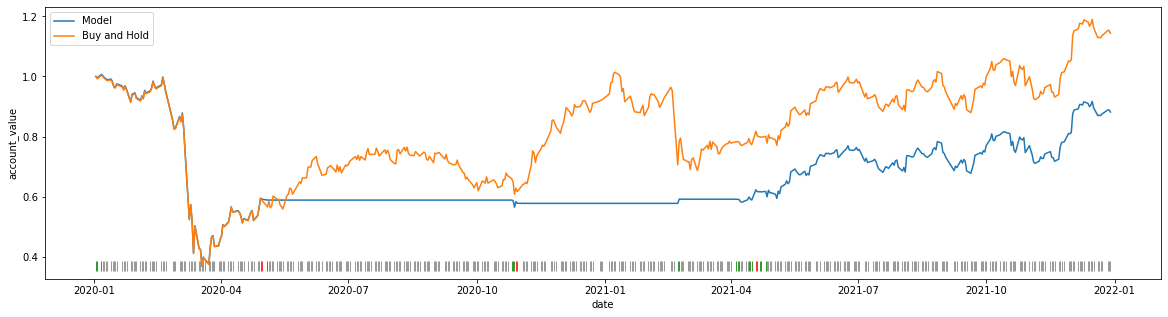

MODEL TIMESTEPS: 11632


,Model,Buy and Hold
Annual return,0.093699,0.072482
Cumulative returns,0.187704,0.143848
Annual volatility,0.425917,0.580281
Sharpe ratio,0.425868,0.424109
Calmar ratio,0.193766,0.114405
Stability,0.406188,0.398792
Max drawdown,-0.483567,-0.633561
Omega ratio,1.135444,1.089995
Sortino ratio,0.604518,0.567288
Skew,NaN,NaN


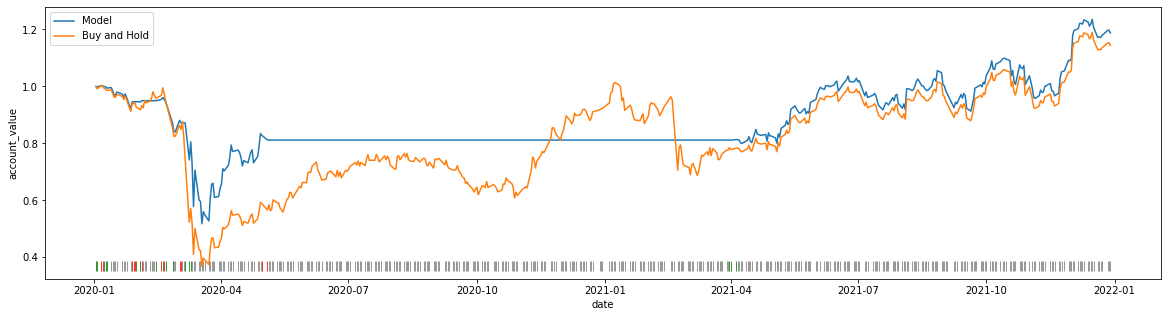

MODEL TIMESTEPS: 13813


,Model,Buy and Hold
Annual return,0.024560,0.072482
Cumulative returns,0.047703,0.143848
Annual volatility,0.470592,0.580281
Sharpe ratio,0.299987,0.424109
Calmar ratio,0.042246,0.114405
Stability,0.235166,0.398792
Max drawdown,-0.581351,-0.633561
Omega ratio,1.096032,1.089995
Sortino ratio,0.395452,0.567288
Skew,NaN,NaN


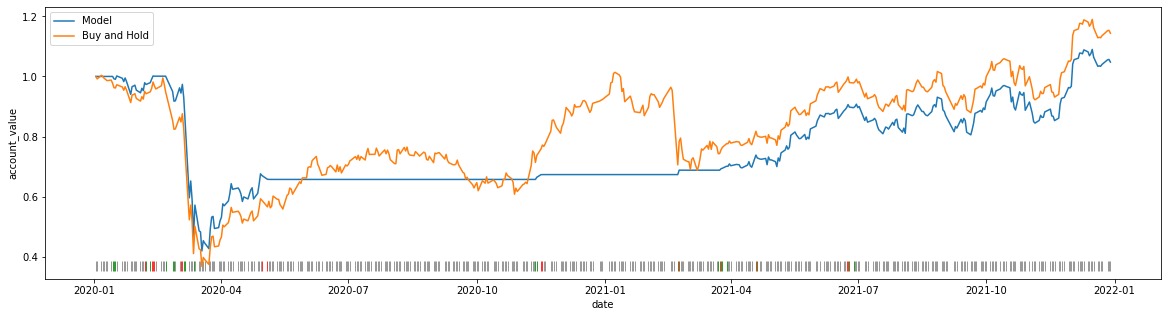

MODEL TIMESTEPS: 14540


,Model,Buy and Hold
Annual return,-0.000497,0.072482
Cumulative returns,-0.000954,0.143848
Annual volatility,0.469832,0.580281
Sharpe ratio,0.245669,0.424109
Calmar ratio,-0.000842,0.114405
Stability,0.198943,0.398792
Max drawdown,-0.589796,-0.633561
Omega ratio,1.077298,1.089995
Sortino ratio,0.325715,0.567288
Skew,NaN,NaN


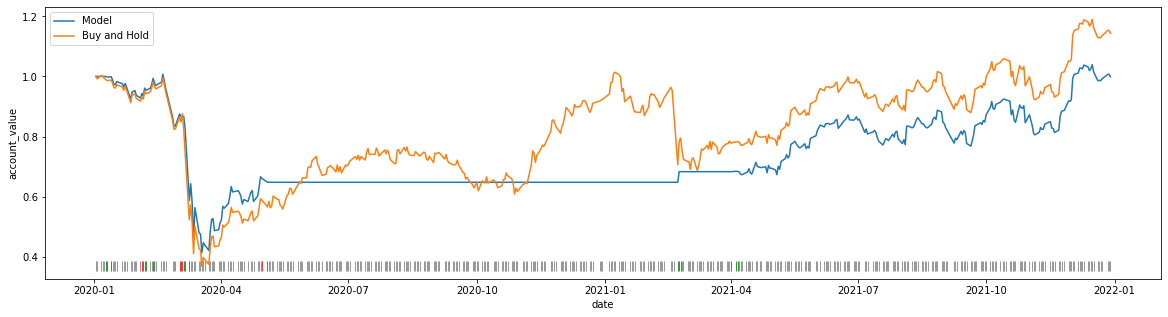

MODEL TIMESTEPS: 14540


,Model,Buy and Hold
Annual return,0.017023,0.072482
Cumulative returns,0.032952,0.143848
Annual volatility,0.432436,0.580281
Sharpe ratio,0.257688,0.424109
Calmar ratio,0.033220,0.114405
Stability,0.119758,0.398792
Max drawdown,-0.512444,-0.633561
Omega ratio,1.077876,1.089995
Sortino ratio,0.361887,0.567288
Skew,NaN,NaN


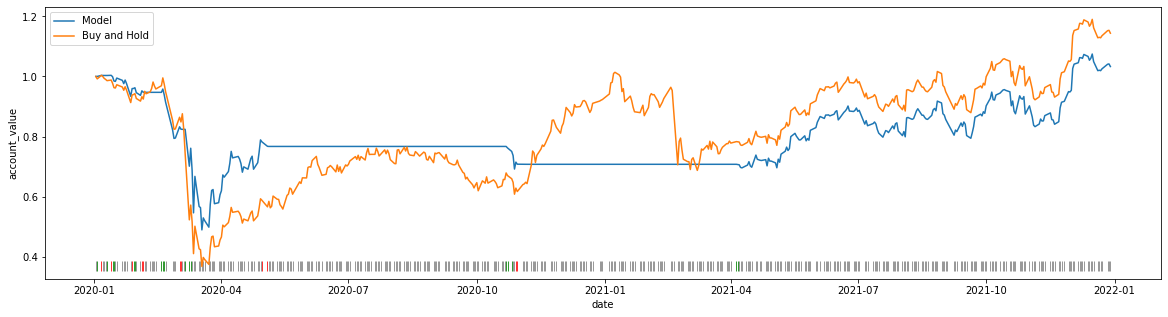

In [73]:
df_result = pd.DataFrame()
for i in range(10):

    best_model_path = os.path.join(
        Path(HYPERPARAMETERS_PATH).parent,
        'retrain_and_evaluation',
        str(i)
    )

    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        use_invert_action_env = False,
        algorithm=args['alg'],
        train_episodes=20,
        model_params=best_params,
        return_best_model=True,
        best_model_path=best_model_path
    )

    temp_result = predict_and_evaluate(model)

    df_result = pd.concat([df_result, temp_result])

display(df_result.reset_index().groupby('index').agg(['mean', 'std']))

## With Inverted Action

MODEL TIMESTEPS: 66884


,Model,Buy and Hold
Annual return,0.129624,0.072482
Cumulative returns,0.263765,0.143848
Annual volatility,0.539716,0.580281
Sharpe ratio,0.504182,0.424109
Calmar ratio,0.228192,0.114405
Stability,0.458124,0.398792
Max drawdown,-0.568047,-0.633561
Omega ratio,1.108054,1.089995
Sortino ratio,0.688393,0.567288
Skew,NaN,NaN


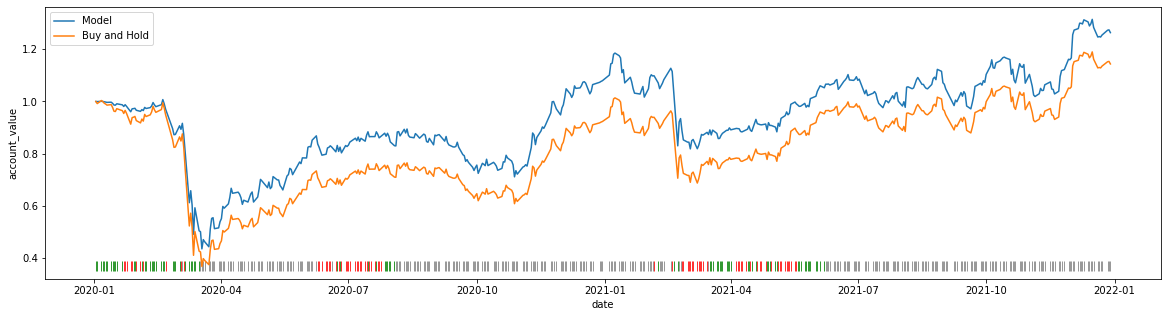

MODEL TIMESTEPS: 65430


,Model,Buy and Hold
Annual return,-0.207451,0.072482
Cumulative returns,-0.360168,0.143848
Annual volatility,0.379864,0.580281
Sharpe ratio,-0.410796,0.424109
Calmar ratio,-0.354418,0.114405
Stability,0.000026,0.398792
Max drawdown,-0.585329,-0.633561
Omega ratio,0.894485,1.089995
Sortino ratio,-0.504905,0.567288
Skew,NaN,NaN


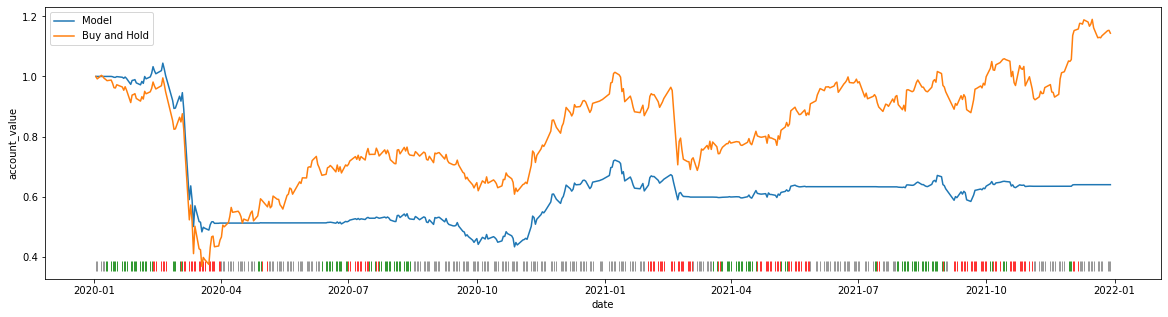

MODEL TIMESTEPS: 66884


,Model,Buy and Hold
Annual return,0.377786,0.072482
Cumulative returns,0.850620,0.143848
Annual volatility,0.427032,0.580281
Sharpe ratio,0.967145,0.424109
Calmar ratio,0.955417,0.114405
Stability,0.810532,0.398792
Max drawdown,-0.395415,-0.633561
Omega ratio,1.196017,1.089995
Sortino ratio,1.410270,0.567288
Skew,NaN,NaN


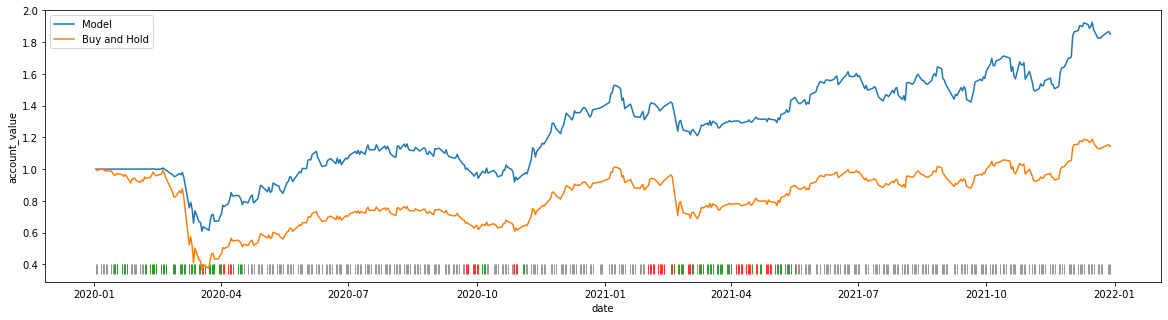

MODEL TIMESTEPS: 71246


,Model,Buy and Hold
Annual return,0.206647,0.072482
Cumulative returns,0.434451,0.143848
Annual volatility,0.264635,0.580281
Sharpe ratio,0.842621,0.424109
Calmar ratio,0.801477,0.114405
Stability,0.482893,0.398792
Max drawdown,-0.257832,-0.633561
Omega ratio,1.328566,1.089995
Sortino ratio,1.343300,0.567288
Skew,NaN,NaN


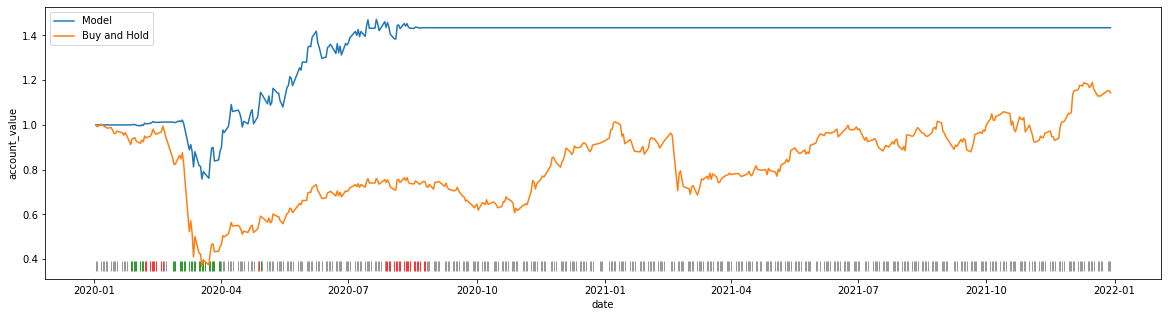

MODEL TIMESTEPS: 65430


,Model,Buy and Hold
Annual return,-0.041033,0.072482
Cumulative returns,-0.077319,0.143848
Annual volatility,0.530330,0.580281
Sharpe ratio,0.200948,0.424109
Calmar ratio,-0.067890,0.114405
Stability,0.186207,0.398792
Max drawdown,-0.604405,-0.633561
Omega ratio,1.042357,1.089995
Sortino ratio,0.259784,0.567288
Skew,NaN,NaN


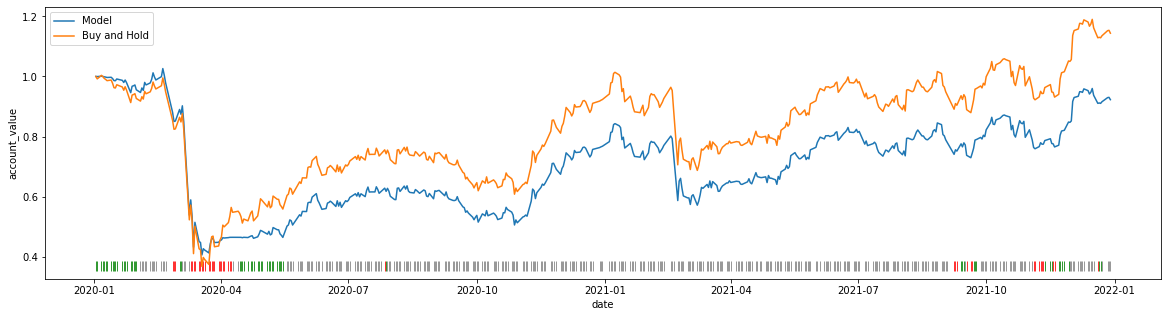

MODEL TIMESTEPS: 72700


,Model,Buy and Hold
Annual return,0.093160,0.072482
Cumulative returns,0.186582,0.143848
Annual volatility,0.431494,0.580281
Sharpe ratio,0.427886,0.424109
Calmar ratio,0.171038,0.114405
Stability,0.404498,0.398792
Max drawdown,-0.544676,-0.633561
Omega ratio,1.125930,1.089995
Sortino ratio,0.587768,0.567288
Skew,NaN,NaN


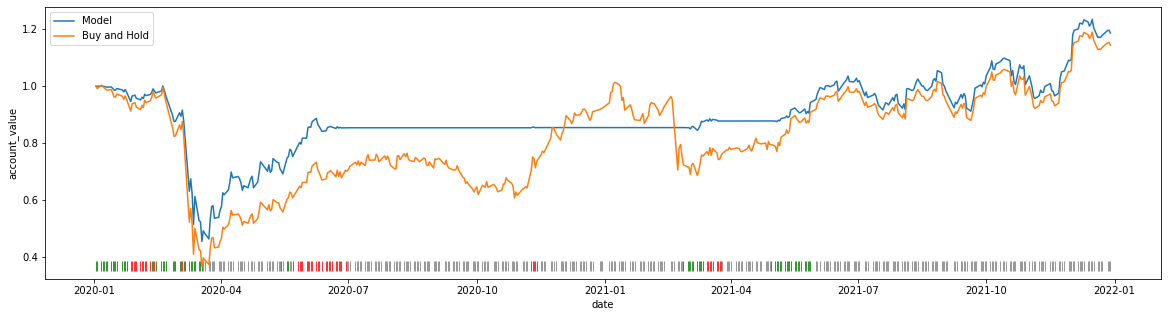

MODEL TIMESTEPS: 24718


,Model,Buy and Hold
Annual return,0.229422,0.072482
Cumulative returns,0.486903,0.143848
Annual volatility,0.445330,0.580281
Sharpe ratio,0.691970,0.424109
Calmar ratio,0.433839,0.114405
Stability,0.656502,0.398792
Max drawdown,-0.528818,-0.633561
Omega ratio,1.182383,1.089995
Sortino ratio,0.973438,0.567288
Skew,NaN,NaN


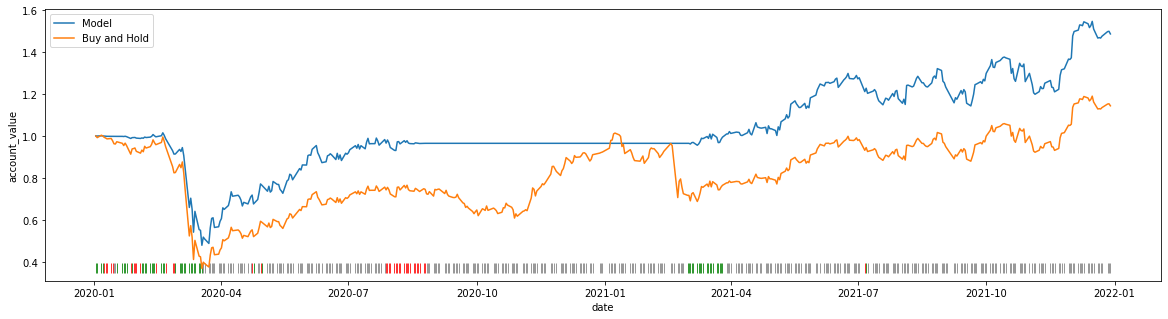

MODEL TIMESTEPS: 72700


,Model,Buy and Hold
Annual return,-0.122602,0.072482
Cumulative returns,-0.222140,0.143848
Annual volatility,0.458361,0.580281
Sharpe ratio,-0.042072,0.424109
Calmar ratio,-0.194688,0.114405
Stability,0.002180,0.398792
Max drawdown,-0.629735,-0.633561
Omega ratio,0.986858,1.089995
Sortino ratio,-0.053457,0.567288
Skew,NaN,NaN


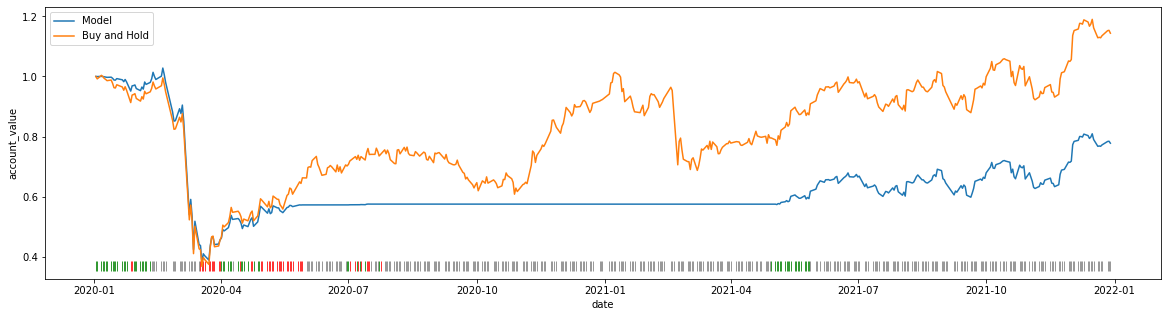

MODEL TIMESTEPS: 24718


,Model,Buy and Hold
Annual return,0.433664,0.072482
Cumulative returns,0.997460,0.143848
Annual volatility,0.313683,0.580281
Sharpe ratio,1.307384,0.424109
Calmar ratio,1.909842,0.114405
Stability,0.778145,0.398792
Max drawdown,-0.227068,-0.633561
Omega ratio,1.326452,1.089995
Sortino ratio,2.097105,0.567288
Skew,NaN,NaN


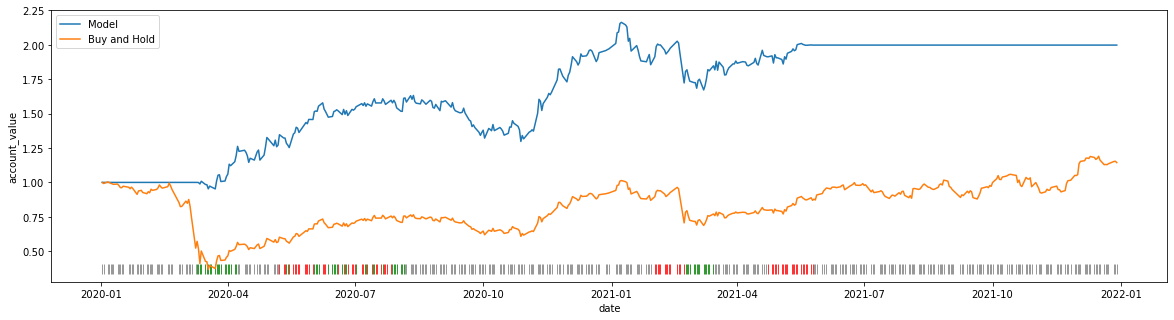

MODEL TIMESTEPS: 72700


,Model,Buy and Hold
Annual return,0.095242,0.072482
Cumulative returns,0.190924,0.143848
Annual volatility,0.578101,0.580281
Sharpe ratio,0.459903,0.424109
Calmar ratio,0.151849,0.114405
Stability,0.412886,0.398792
Max drawdown,-0.627212,-0.633561
Omega ratio,1.098901,1.089995
Sortino ratio,0.615661,0.567288
Skew,NaN,NaN


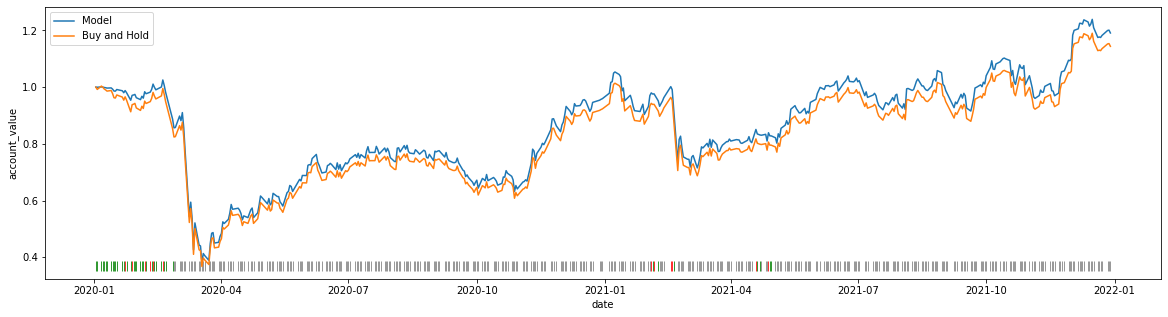

In [ ]:
df_result = pd.DataFrame()
for i in range(10):

    best_model_path = os.path.join(
        Path(HYPERPARAMETERS_PATH).parent,
        'retrain_and_evaluation',
        str(i)
    )

    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        use_invert_action_env = True,
        algorithm=args['alg'],
        train_episodes=20,
        model_params=best_params,
        return_best_model=True,
        best_model_path=best_model_path
    )

    temp_result = predict_and_evaluate(model)

    df_result = pd.concat([df_result, temp_result])

display(df_result.reset_index().groupby('index').agg(['mean', 'std']))



MODEL TIMESTEPS: 29080


,Model,Buy and Hold
Annual return,0.075358,0.072482
Cumulative returns,0.149746,0.143848
Annual volatility,0.505637,0.580281
Sharpe ratio,0.409007,0.424109
Calmar ratio,0.119533,0.114405
Stability,0.391735,0.398792
Max drawdown,-0.630439,-0.633561
Omega ratio,1.108040,1.089995
Sortino ratio,0.546890,0.567288
Skew,NaN,NaN


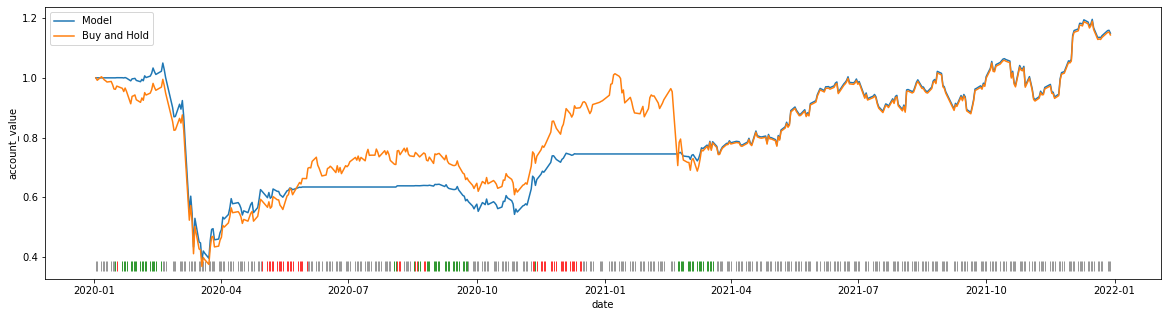

MODEL TIMESTEPS: 29807


,Model,Buy and Hold
Annual return,0.139046,0.072482
Cumulative returns,0.284090,0.143848
Annual volatility,0.520253,0.580281
Sharpe ratio,0.522557,0.424109
Calmar ratio,0.220560,0.114405
Stability,0.529115,0.398792
Max drawdown,-0.630424,-0.633561
Omega ratio,1.129493,1.089995
Sortino ratio,0.708139,0.567288
Skew,NaN,NaN


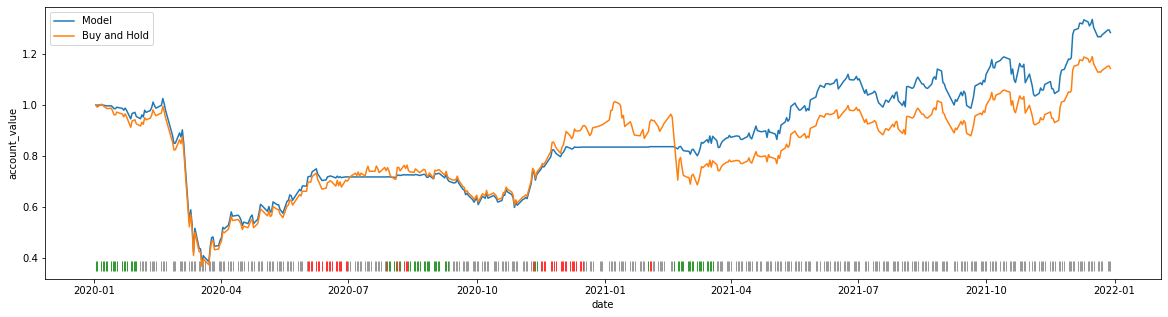

MODEL TIMESTEPS: 26172


,Model,Buy and Hold
Annual return,0.066540,0.072482
Cumulative returns,0.131706,0.143848
Annual volatility,0.493063,0.580281
Sharpe ratio,0.390171,0.424109
Calmar ratio,0.105553,0.114405
Stability,0.402727,0.398792
Max drawdown,-0.630391,-0.633561
Omega ratio,1.107604,1.089995
Sortino ratio,0.517423,0.567288
Skew,NaN,NaN


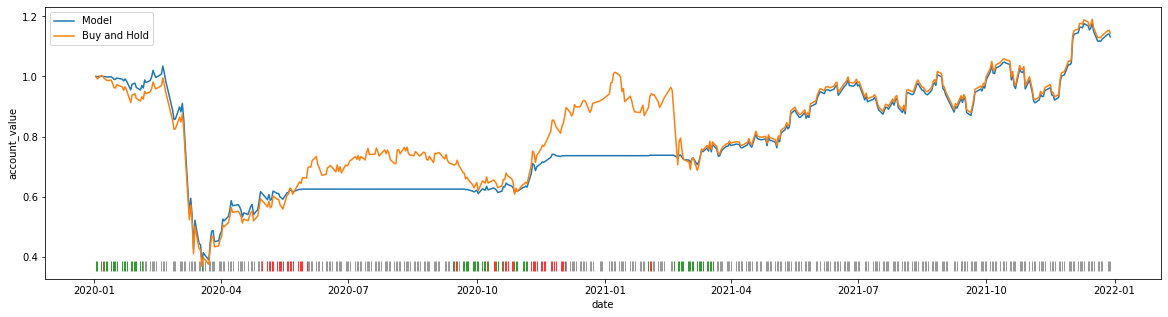

MODEL TIMESTEPS: 18902


,Model,Buy and Hold
Annual return,-0.009689,0.072482
Cumulative returns,-0.018525,0.143848
Annual volatility,0.482375,0.580281
Sharpe ratio,0.234016,0.424109
Calmar ratio,-0.015457,0.114405
Stability,0.159628,0.398792
Max drawdown,-0.626795,-0.633561
Omega ratio,1.069625,1.089995
Sortino ratio,0.307022,0.567288
Skew,NaN,NaN


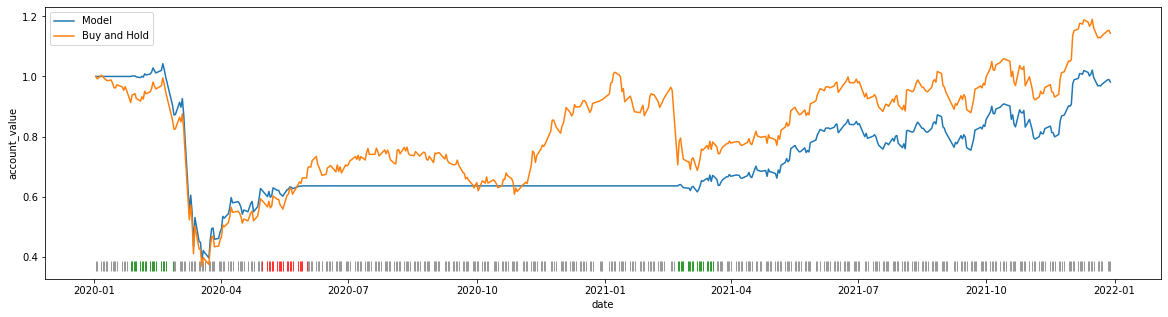

MODEL TIMESTEPS: 35623


,Model,Buy and Hold
Annual return,0.102324,0.072482
Cumulative returns,0.205758,0.143848
Annual volatility,0.499203,0.580281
Sharpe ratio,0.457618,0.424109
Calmar ratio,0.162317,0.114405
Stability,0.465088,0.398792
Max drawdown,-0.630392,-0.633561
Omega ratio,1.126375,1.089995
Sortino ratio,0.610494,0.567288
Skew,NaN,NaN


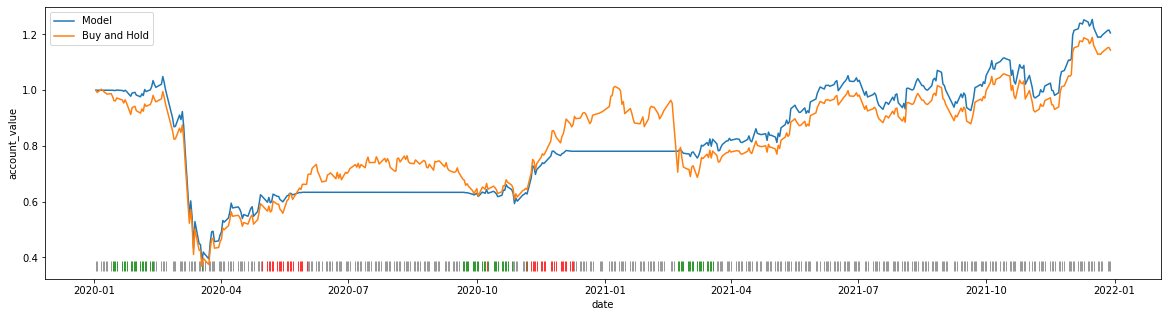

In [29]:
for i in range(5):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=50,
        model_params=best_params,
        return_best_model=True,
        best_model_path=best_model_path
    )

    predict_and_evaluate(model)